In [3]:
!pip install langchain -q
!pip install openai -q

In [4]:
import numpy as np
import pandas as pd
import sqlite3

In [5]:
df = pd.read_csv('/content/income (1).csv')

In [6]:
df.rename(columns={
    'Name':'name',
    'Age':'age',
    'Income($)':'income'
})

,name,age,income
0,Rob,27,70000
1,Michael,29,90000
2,Mohan,29,61000
3,Ismail,28,60000
4,Kory,42,150000
5,Gautam,39,155000
6,David,41,160000
7,Andrea,38,162000
8,Brad,36,156000
9,Angelina,35,130000


In [7]:
conn = sqlite3.connect('income.sqlite')
c=conn.cursor()
c.execute('CREATE TABLE IF NOT EXISTS income_details (name text, age int,income int)')
conn.commit()

In [8]:
df.to_sql('income_details', conn, if_exists='replace', index = False)

c.execute('''
SELECT name FROM income_details LIMIT 10
           ''')

for row in c.fetchall():
  print (row)


('Rob',)
('Michael',)
('Mohan',)
('Ismail',)
('Kory',)
('Gautam',)
('David',)
('Andrea',)
('Brad',)
('Angelina',)


###Reading the db

In [9]:
def read_sql_query(sql, db):
    conn = sqlite3.connect(db)
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    for row in rows:
        print(row)
    conn.close()

In [10]:
read_sql_query('SELECT * FROM income_details LIMIT 10;',
               "income.sqlite")

('Rob', 27, 70000)
('Michael', 29, 90000)
('Mohan', 29, 61000)
('Ismail', 28, 60000)
('Kory', 42, 150000)
('Gautam', 39, 155000)
('David', 41, 160000)
('Andrea', 38, 162000)
('Brad', 36, 156000)
('Angelina', 35, 130000)


###Langchain SQL Agent

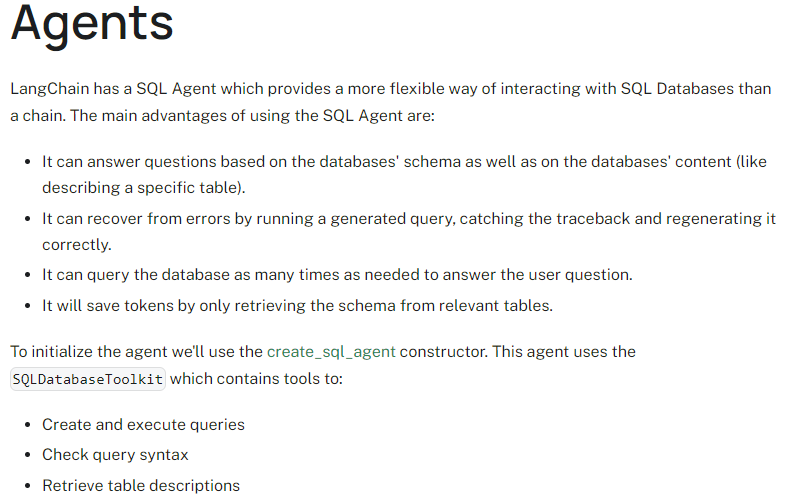

In [11]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00


In [12]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = 'OPENAI_API_KEY'

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [13]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///income.sqlite")
#content/income.sqlite
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM income_details;")

sqlite
['income_details']


"[('Rob', 27, 70000), ('Michael', 29, 90000), ('Mohan', 29, 61000), ('Ismail', 28, 60000), ('Kory', 42, 150000), ('Gautam', 39, 155000), ('David', 41, 160000), ('Andrea', 38, 162000), ('Brad', 36, 156000), ('Angelina', 35, 130000), ('Donald', 37, 137000), ('Tom', 26, 45000), ('Arnold', 27, 48000), ('Jared', 28, 51000), ('Stark', 29, 49500), ('Ranbir', 32, 53000), ('Dipika', 40, 65000), ('Priyanka', 41, 63000), ('Nick', 43, 64000), ('Alia', 39, 80000), ('Sid', 41, 82000), ('Abdul', 39, 58000)]"

In [14]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [23]:
agent_executor.invoke(
    {
        "input": "List the youngest and the oldest person, also list folks who have the least and highest salary??"
    }
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


income_details
Invoking: `sql_db_schema` with `{'table_names': 'income_details'}`



CREATE TABLE income_details (
	"Name" TEXT, 
	"Age" INTEGER, 
	"Income($)" INTEGER
)

/*
3 rows from income_details table:
Name	Age	Income($)
Rob	27	70000
Michael	29	90000
Mohan	29	61000
*/
Invoking: `sql_db_query` with `{'query': 'SELECT Name, Age FROM income_details ORDER BY Age ASC LIMIT 1'}`


[('Tom', 26)]
Invoking: `sql_db_query` with `{'query': 'SELECT Name, Age FROM income_details ORDER BY Age DESC LIMIT 1'}`


[('Nick', 43)]
Invoking: `sql_db_query` with `{'query': 'SELECT Name, Age, Income($) FROM income_details ORDER BY Income($) ASC LIMIT 1'}`


Error: (sqlite3.OperationalError) unrecognized token: "$"
[SQL: SELECT Name, Age, Income($) FROM income_details ORDER BY Income($) ASC LIMIT 1]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_query` with `{'query': 'SELECT Name, Ag

{'input': 'List the youngest and the oldest person, also list folks who have the least and highest salary??',
 'output': 'The youngest person is Tom, aged 26, and the oldest person is Nick, aged 43.\n\nThe person with the least salary is Tom, with an income of $45,000, and the person with the highest salary is Andrea, with an income of $162,000.'}

In [15]:
agent_executor.invoke(
    "Name people with age more than 27 and salary more than $35,000"
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


income_details
Invoking: `sql_db_schema` with `{'table_names': 'income_details'}`



CREATE TABLE income_details (
	"Name" TEXT, 
	"Age" INTEGER, 
	"Income($)" INTEGER
)

/*
3 rows from income_details table:
Name	Age	Income($)
Rob	27	70000
Michael	29	90000
Mohan	29	61000
*/
Invoking: `sql_db_query` with `{'query': 'SELECT Name, Age, Income($) FROM income_details WHERE Age > 27 AND Income($) > 35000'}`


Error: (sqlite3.OperationalError) unrecognized token: "$"
[SQL: SELECT Name, Age, Income($) FROM income_details WHERE Age > 27 AND Income($) > 35000]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_query` with `{'query': 'SELECT Name, Age, "Income($)" FROM income_details WHERE Age > 27 AND "Income($)" > 35000'}`
responded: I made a mistake in the query by using a column name with special characters. Let me correct it and try again.

[('Michael', 29, 90000), ('Mohan', 2

{'input': 'Name people with age more than 27 and salary more than $35,000',
 'output': 'The people with age more than 27 and salary more than $35,000 are:\n\n1. Michael, Age: 29, Income: $90,000\n2. Mohan, Age: 29, Income: $61,000\n3. Ismail, Age: 28, Income: $60,000\n4. Kory, Age: 42, Income: $150,000\n5. Gautam, Age: 39, Income: $155,000\n6. David, Age: 41, Income: $160,000\n7. Andrea, Age: 38, Income: $162,000\n8. Brad, Age: 36, Income: $156,000\n9. Angelina, Age: 35, Income: $130,000\n10. Donald, Age: 37, Income: $137,000\n\n(Note: Only the first 10 results are shown)'}

In [16]:
agent_executor.invoke(
    "Can you sum the age of folks who have salary more than $150,000"
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


income_details
Invoking: `sql_db_schema` with `{'table_names': 'income_details'}`



CREATE TABLE income_details (
	"Name" TEXT, 
	"Age" INTEGER, 
	"Income($)" INTEGER
)

/*
3 rows from income_details table:
Name	Age	Income($)
Rob	27	70000
Michael	29	90000
Mohan	29	61000
*/
Invoking: `sql_db_query` with `{'query': 'SELECT SUM(Age) AS Total_Age FROM income_details WHERE "Income($)" > 150000'}`


[(154,)]The total age of folks who have a salary more than $150,000 is 154.

> Finished chain.


{'input': 'Can you sum the age of folks who have salary more than $150,000',
 'output': 'The total age of folks who have a salary more than $150,000 is 154.'}